In [1]:
# Pandas is used for data manipulation
import pandas as pd
import numpy as np
# usar Skicit-learn para dividir los datos en entrenamiento y validación
from sklearn.model_selection import train_test_split
# Importar el modelo que vamos a usar
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot# Saca un árbol del bosque
from IPython.display import SVG
from graphviz import Source
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from pandas.tools.plotting import scatter_matrix

Error mae donde $y$ es el valor real $\hat{y}$ es el valor predicho y N es el total de datos
\begin{equation}
mae = \frac{1}{N}\sum\limits_{i=0}^{N}|\hat{y_{i}}-y_{i}|
\end{equation}

Error mse
\begin{equation}
mse = \frac{1}{N}\sum\limits_{i=0}^{N}(\hat{y_{i}}-y_{i})^{2}
\end{equation}

Error rmse
\begin{equation}
rmse = \sqrt{\frac{\sum\limits_{i=0}^{N}(\hat{y_{i}}-y_{i})^{2}}{N}}
\end{equation}

Error mape
\begin{equation}
mape = \frac{100\%}{N} \sum\limits_{i=1}^{N} |\frac{y_{i}-\hat{y_{i}}}{y_{i}}|
\end{equation}

In [2]:
def smape(y_true, y_predict):
    return 100/len(y_true) * np.sum(2 * np.abs(y_predict - y_true) / (np.abs(y_true) + np.abs(y_predict)))

In [3]:
def regresorBosquesAleatorios(numArb,numDatos,analiVarImp=1,porcVali=0.3):
    # Read in data as pandas dataframe and display first 5 rows
    caracte = pd.read_csv('regresor/errores_prediccion_smape.csv')
    # Shuffle
    print("Base de datos de caracteristicas y error\n",caracte[0:10])
    caracte = caracte.reindex(np.random.permutation(caracte.index))
    caracte = caracte[0:numDatos]
    caracte
    print("Base de datos de caracteristicas y error con intercambio de indices\n",caracte[0:10])
    
    #Características y etiquetas
    # Las etiquetas son los valores que queremos predecir
    objetivo = np.array(caracte['smape pronostico'])
    # Eliminar las etiquetas de las funciones
    # eje 1 se refiere a las columnas
    caracte= caracte.drop('smape pronostico', axis = 1)
    # Guardar nombres de funciones para su uso posterior
    listaCaracte = list(caracte.columns)
    # Convertir arreglo numpy
    caracte = np.array(caracte)
    caracte
    
    
    #Preparación de los datos
    # Divide los datos en conjuntos de entrenamiento y prueba
    entreCaracte, validaCaracte, entreObjetivo, validaObjetivo = train_test_split(caracte, objetivo, 
                                                                                test_size = porcVali)#,
                                                                           #random_state = 42)
    print('Entrenamiento caracteristicas dimensiones:', entreCaracte.shape)
    print('Entrenamiento objetivo dimensiones:', entreObjetivo.shape)
    print('Validacion caracteristicas dimensiones:', validaCaracte.shape)
    print('Validacion objetivo dimensiones:', validaObjetivo.shape)
    
    
    # Inicialización del modelo 
    rf = RandomForestRegressor(n_estimators= numArb,criterion="mse",n_jobs=-1,verbose=1)#, random_state=42)
    # Entrenar el modelo con los datos de entrenamiento
    print("entreCaracte\n",entreCaracte,"\n\nentreObjetivo",entreObjetivo)
    rf.fit(entreCaracte, entreObjetivo);
    rf.decision_path(entreCaracte)
    
    #Hacer predicciones sobre datos de validación
    #Usando el método de predicción del bosque en los datos de prueba
    predicciones = rf.predict(validaCaracte)
    #Calculando el error absoluto
    errors = abs(predicciones - validaObjetivo)
    #Calculando el error absoluto medio
    print('mae:', round(np.mean(errors), 4))
    
    # Calculando el error porcentual absoluto medio (MAPE)
    mape = 100 * (errors / validaObjetivo)
    smape1 = smape(validaObjetivo,predicciones)
    # Calculando RMSE
    rmse = np.sqrt(np.sum(np.power((predicciones-validaObjetivo),2)) / len(predicciones))
    print("rmse",rmse,"smape",smape1)
    # Calcular y mostrar precisión
    precision = 100 - np.mean(mape)
    print('precision buena:', round(precision, 4), '%.')
    print("precision con smape",100-smape1)
#     scatter_matrix(caracte, figsize=(12, 8))
    if analiVarImp == 1:
        #Variables importantes
        # Obtener la importancias de características numéricas
        importantes = list(rf.feature_importances_)
        # Lista de tuplas con variable e importancia.
        caracte_importantes = [(caracte, round(importance, 2)) for caracte, importance in zip(listaCaracte, importantes)]
        # Ordena las características por las más importantes primero
        caracte_importantes = sorted(caracte_importantes, key = lambda x: x[1], reverse = True)
        # Imprima la característica y las importancias
        [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in caracte_importantes];


        #Dos características más importantes
        # New random forest with only the two most important variables
        rfMasImportantes = RandomForestRegressor(n_estimators= numArb)
        # Extract the two most important caracte
        indicesImportantes = [listaCaracte.index('1/SNR'), listaCaracte.index('Caos')]
        entreImportantes = entreCaracte[:, indicesImportantes]
        valiImportantes = validaCaracte[:, indicesImportantes]
        # Train the random forest
        rfMasImportantes.fit(entreImportantes, entreObjetivo)
        # Make predicciones and determine the error
        predicciones = rfMasImportantes.predict(valiImportantes)
        errors = abs(predicciones - validaObjetivo)
        # Display the performance metrics
        print('mae:', round(np.mean(errors), 2))
        mape = np.mean(100 * (errors / validaObjetivo))
        precision = 100 - mape
        print('precision:', round(precision, 2), '%.')

        # Visualizaciones
        # Estilo del plot 
        plt.style.use('fivethirtyeight')
        # lista de ubicaciones x para dibujar
        valoresX = list(range(len(importantes)))
        # gráfico de barras
        plt.bar(valoresX, importantes, orientation = 'vertical')
        # Marque las etiquetas para el eje x
        plt.xticks(valoresX, listaCaracte, rotation='vertical')
        # Etiquetas y título del eje
        plt.ylabel('Importancia'); plt.xlabel('Variable'); plt.title('Importancia de las variables'); 

        # Importar herramientas necesarias para la visualización
    arbol = rf.estimators_[5]# Export the image to a dot file
    print("tamano stimators",len(rf.estimators_),"n_features_",rf.n_features_)
    export_graphviz(arbol, out_file = 'arbol.dot', feature_names = listaCaracte, rounded = True, precision = 1)# Use dot file to create a graph
    #     (graph, ) = pydot.graph_from_dot_file('arbol.dot')# Write graph to a png file
    #     graph.write_png('arbol.png')
    return rf 

In [10]:
def calidadSt(inicio,numDatos,modelo):
    # Read in data as pandas dataframe and display first 5 rows
    features = pd.read_csv('regresor/errores_prediccion_smape.csv')
    # Shuffle
    #features = features.reindex(np.random.permutation(features.index))
    features = features[inicio:numDatos]
#     print(features)
    
    #Características y etiquetas
    # Las etiquetas son los valores que queremos predecir
    labels = np.array(features['smape pronostico'])
    # Eliminar las etiquetas de las funciones
    # eje 1 se refiere a las columnas
    features= features.drop('smape pronostico', axis = 1)
    # Guardar nombres de funciones para su uso posterior
    feature_list = list(features.columns)
    # Convertir arreglo numpy
    features = np.array(features)
#     features

    print('Caracteristicas dimensiones:', features.shape)
    print('Caracteristicas:', features)
    print('Predicciones dimensiones:', labels.shape)
    
    # Load from file
    with open(modelo, 'rb') as file:
        rf = pickle.load(file)
#     print("rf",rf)
#     # Calculate the accuracy score and predict target values
#     score = rf.score(Xtest, Ytest)
#     print("Test score: {0:.2f} %".format(100 * score))
#     Ypredict = pickle_model.predict(Xtest)
    
    #Hacer predicciones sobre datos de validación
    #Usando el método de predicción del bosque en los datos de prueba
    predictions = rf.predict(features)
    print("predictions",float(predictions),"real",float(labels))
    #Calculando el error absoluto
    errors = abs(predictions - labels)
    #Calculando el error absoluto medio
    print('Mean Absolute Error:', round(np.mean(errors), 4))
    
    # Calculando el error porcentual absoluto medio (MAPE)
    mape = 100 * (errors / labels)
    # Calculando RMSE
    rmse = np.sqrt(np.sum(np.power((predictions-labels),2)) / len(predictions))
    print("rmse",rmse)
    # Calcular y mostrar precisión
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 4), '%.')

Base de datos de caracteristicas y error
    Datos Faltantes  Valores Atípicos     1/SNR      Caos  smape pronostico
0                0                 0  0.012627  0.001054          1.123105
1                0                 0  0.039752  0.000761         15.959387
2                0                 0  0.049423 -0.000214         24.011332
3                0                 2  0.065870 -0.000283         36.160149
4                0                 5  0.097306  0.000244         55.047501
5                0                 6  0.188165  0.000052         77.953079
6                0                 3  0.120126 -0.000276         16.034263
7                0                 3  0.125379 -0.001319         26.786634
8                0                 4  0.125767 -0.000345         31.806376
9                0                 6  0.134303 -0.000545         44.889877
Base de datos de caracteristicas y error con intercambio de indices
       Datos Faltantes  Valores Atípicos     1/SNR      Caos  sma

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | e

mae: 6.318
rmse 9.615103457476152 smape 13.972947752543062
precision buena: 85.0789 %.
precision con smape 86.02705224745694
Variable: 1/SNR                Importance: 0.84
Variable: Caos                 Importance: 0.09
Variable: Valores Atípicos     Importance: 0.05
Variable: Datos Faltantes      Importance: 0.02
mae: 7.61
precision: 83.2 %.
tamano stimators 2000 n_features_ 4


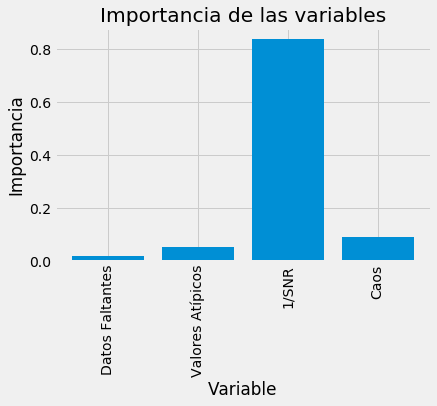

In [14]:
rf = regresorBosquesAleatorios(2000,2160,analiVarImp=1,porcVali=0.3)

In [126]:
# Guardar el modelo en el directorio actual
pkl_filename = "rfModelo2.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf, file)

In [18]:
from time import time
tiempoini = time()
calidadSt(200,201,"rfModelo.pkl")
print("tardo",time()-tiempoini)

Caracteristicas dimensiones: (1, 4)
Caracteristicas: [[2.50000000e+01 4.00000000e+00 1.89012622e-01 5.64354200e-04]]
Predicciones dimensiones: (1,)


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s


predictions 44.95726691112597 real 43.6317777599963
Mean Absolute Error: 1.3255
rmse 1.3254891511296734
Accuracy: 96.9621 %.
tardo 0.438129186630249


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [130]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

# # Calculate the accuracy score and predict target values
# score = pickle_model.score(Xtest, Ytest)
# print("Test score: {0:.2f} %".format(100 * score))
# Ypredict = pickle_model.predict(Xtest)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)


In [20]:
print(rf.estimators_.tree_.children_left)

AttributeError: 'list' object has no attribute 'tree_'

In [7]:
def calidadCaracteristicas(caracteristicas,modelo):
    # Read in data as pandas dataframe and display first 5 rows
    features = np.array(caracteristicas)
#     features

    print('Caracteristicas dimensiones:', features.shape)
    print('Caracteristicas:', features)
    
    # Load from file
    with open(modelo, 'rb') as file:
        rf = pickle.load(file)

    #Hacer predicciones sobre datos de validación
    #Usando el método de predicción del bosque en los datos de prueba
    predictions = rf.predict(features)
    print("predictions",predictions)

In [12]:
calidadCaracteristicas([[0,0,0,0.0001051]],"rfModelo.pkl")

Caracteristicas dimensiones: (1, 4)
Caracteristicas: [[0.        0.        0.        0.0001051]]


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s


predictions [7.51046455]


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.2s finished
